In [1]:
# !pip install transformers   #Installare libreria transformers per usare librerie di Bert
!pip install wandb

In [2]:
import sys

sys.path.append('/home/michieletto/hmp_utils')
if '../' not in sys.path:
    sys.path.append('../')

In [3]:
import json
import glob
import os
import random

from hmp_utils.motion.body_models_constants import SmplConstants
from hmp_utils.motion.mocap_processor import MocapLoader
from hmp_utils.motion.kinematics import ForwardKinematics
from hmp_utils.visualize.stickman_animation import pose_animation, CameraOrientation, AnimationMode

import torch
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import tqdm
import numpy as np
import pandas as pd
import wandb
import time

In [4]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pietro-mercorella (csquare). Use `wandb login --relogin` to force relogin


True

 Creazione del dataset di Bert: dizionario con tutte le informazioni contenute nei file

In [5]:
dataset = []

# Definisci il percorso completo del file JSON
percorso_file_train = '/home/michieletto/datasets/BABEL_DATASET/babel_v1.0_release/train.json'
percorso_file_val   = '/home/michieletto/datasets/BABEL_DATASET/babel_v1.0_release/val.json'
percorso_file_test  = '/home/michieletto/datasets/BABEL_DATASET/babel_v1.0_release/test.json'

dataset.append(percorso_file_train)
dataset.append(percorso_file_val)
dataset.append(percorso_file_test)

data = {}           # Dizionario contenente l'intero dataset  

# Apre il file JSON in modalità lettura
for i,percorso_file in enumerate(dataset):
    with open(percorso_file, 'r') as f:
        # Carica i dati JSON
        data.update(json.load(f))


Estrazione dal dataset delle informzaioni essenziali: raw_label e feat_p (percorso file)

In [6]:

occur_lab = {
    'label': [],              
    'feat_p': []
    }

no_lab = 0

# Creazione del dataset contenente tutte le raw_label, passaggi cartelle e le action
for i, k in enumerate(data.keys()):
    label = data[k]["seq_ann"]["labels"][0]["raw_label"]
    feat_p = data[k]["feat_p"]

    if label is not None:
        occur_lab["label"].append(label)
        occur_lab["feat_p"].append(feat_p)
    else:
        no_lab += 1
            

print("Dati totali: ", len(data))
print("Dati con label: ", len(occur_lab["label"]))
print("Dati senza label:", no_lab)
print("num label, paths:", len(occur_lab["label"]), len(occur_lab["feat_p"]))


Dati totali:  10892
Dati con label:  8808
Dati senza label: 2084
num label, paths: 8808 8808


Creazione del dataset Amass ed estrazione random di un file per verificare se e come viene descritto da Babel (valutando se i percorsi file /ultima_cartella/nome_file.npz corrispondono)

In [7]:

directory = '/home/michieletto/datasets/AMASS_H/ACCAD'
file_paths = glob.glob(directory + '/**/*.npz', recursive=True) # ottiene tutti i file nelle diverse cartelle contenenti i mocap in una stringa

directory = '/home/michieletto/datasets/AMASS_H/KIT'
file_paths += glob.glob(directory + '/**/*.npz', recursive=True)

file_paths = sorted(file_paths)
print(len(file_paths))

rand_x = random.randint(0, len(file_paths))
filepath = file_paths[rand_x]

file_name = os.path.basename(filepath)    # ottiene il nome del file
folder_path = os.path.dirname(filepath)   # ottiene il percorso fino alla cartella in cui è contenuto il file
last_folder_name = os.path.basename(folder_path)     # ottiene il nome dell'ultima cartella
last_folder_and_file_name = os.path.join('/', last_folder_name, file_name)     # unisce i due nomi

for i in range(len(occur_lab["feat_p"])):
    if last_folder_and_file_name in occur_lab["feat_p"][i]:
        print(occur_lab["label"][i], occur_lab["feat_p"][i], last_folder_and_file_name)



4484


Creazione del MocapLoader ed estrazione dai file di Amass i frame in forma di matrici 24x3. Successivamente c'è la visualizzazione del primo frame del mocap estratto precedentemente ed il suo viedo.

In [8]:

# frame_to_plot = 1

# -- load mocap --
mocap_loader=MocapLoader(body_model_type=SmplConstants.BODY_MODEL_TYPE,
                         keypoint_ids_to_load=SmplConstants.KEYPOINTS,
                         target_framerate = 25)

motions = []
motions = [mocap_loader.load_mocap(path) for path in file_paths]     # lista delle classi di tutti i mocap
# motion = motions[rand_x]     # selezione casuale di un mocap
# assert motion is not None

# -- compute joint positions --
kine = ForwardKinematics(SmplConstants.OFFSETS, SmplConstants.PARENTS)
kine.set_body_model_type(SmplConstants.BODY_MODEL_TYPE)

all_keypoints_positions = []
for motion in motions:
    if motion is not None:
        all_keypoints_positions.append(kine.compute_fk(motion.rots, apply_root_rotation=True))

# # all_keypoints_positions = [kine.compute_fk(motion.rots, apply_root_rotation=True) for motion in motions]
# keypoints_positions = all_keypoints_positions[rand_x][frame_to_plot]
# print(len(all_keypoints_positions))

# # -- plot --
# # plot_body_keypoints(keypoints_positions, SmplConstants.PARENTS, azimuth=0, keypoint_size = 5, link_size=1, 
# #                     show_keypoint_id=True, body_rotation=(0,0,45))

In [9]:
keypoints_positions = all_keypoints_positions[rand_x][:250]
print(keypoints_positions.shape)

motions_list = [keypoints_positions]
subplot_ids = [0]
subplot_titles = ['Amass']
camera_orientations = [CameraOrientation(100, 20)]
# pose_animation(motions_list, SmplConstants.PARENTS, animation_framerate = 25, subplot_ids=subplot_ids, 
#                camera_orientations=camera_orientations, subplot_titles=subplot_titles,
#                fig_opts={'dpi':90}, animation_mode=AnimationMode.HTML)

(250, 24, 3)


Estrazione dall'intero dataset di Amass di 75 frame per mocap e ridimensionamento di questi da 24x3 a 72.

In [10]:
frame_vocab = []
deleted_paths = []

cont = 0
for i in range(len(motions)):
    if motions[i] is not None:
        if len(motions[i].rots) >= 75:
            rand_x = random.randint(0, len(motions[i].rots) - 75)
            frame_vocab.append(motions[i].rots[rand_x:rand_x + 75])
            assert len(frame_vocab[-1]) == 75

            frame_vocab[-1] = [[angle for k_point in frame for angle in k_point] for frame in frame_vocab[-1]]
            assert len(frame_vocab[-1][0]) == 72
        else:
            frame_vocab.append([])
            deleted_paths.append(i)
            cont +=1
    else:
        frame_vocab.append([])
        deleted_paths.append(i)
        cont += 1


sum = 0
for i in range(len(frame_vocab)):
    sum += len(frame_vocab[i])

print(f"Numero di mocap non validi: {cont}")
print(f"Il numero totale di frame è: {sum}")

Numero di mocap non validi: 131
Il numero totale di frame è: 326475


In [11]:
dataset = {
    'pose': [],
    'description': [],
}

for i in range(len(file_paths)):
    if i not in deleted_paths:
        filepath = file_paths[i]

        file_name = os.path.basename(filepath)    # ottiene il nome del file
        folder_path = os.path.dirname(filepath)   # ottiene il percorso fino alla cartella in cui è contenuto il file
        last_folder_name = os.path.basename(folder_path)     # ottiene il nome dell'ultima cartella
        last_folder_and_file_name = os.path.join('/', last_folder_name, file_name)     # unisce i due nomi
        
        for j in range(len(occur_lab["feat_p"])):
            if last_folder_and_file_name in occur_lab["feat_p"][j]:
                dataset["pose"].append(frame_vocab[i])
                dataset["description"].append(occur_lab["label"][j])

dataset = pd.DataFrame(dataset)
dataset_copy = dataset.copy()

print(len(dataset['pose']), len(dataset['description']))


2726 2726


In [12]:
print(len(dataset["pose"][0]), len(dataset["pose"][0][0]))
print(len(dataset_copy["pose"][0]), len(dataset_copy["pose"][0][0]))

75 72
75 72


In [13]:
# Funzione per eliminare una colonna da ogni matrice
def elimina_colonna(matrice, indexes_to_exclude):

    return [np.delete(row, indexes_to_exclude) for row in matrice]

indexes_to_exclude = [0,1,2, 30,31,32, 33,34,35, 66,67,68, 69,70,71] # Indici corrispondenti ai keypoint 0,10,11,22,23
# Applica la funzione a ogni elemento del DataFrame
dataset["pose"] = dataset["pose"].apply(elimina_colonna, indexes_to_exclude = indexes_to_exclude)

# indexes_to_exclude = [0,1,2, 30,31,32, 33,34,35, 66,67,68, 69,70,71] # Indici corrispondenti ai keypoint 0,10,11,22,23

# for i in range(len(dataset["pose"])):
#     for j in range(len(dataset.iloc[i]["pose"])):
#         dataset.iloc[i]["pose"][j] = [item for idx, item in enumerate(dataset.iloc[i]["pose"][j]) if idx not in indexes_to_exclude]
#         assert len(dataset.iloc[i]["pose"][j]) == 57

In [14]:
print(len(dataset["pose"][0]), len(dataset["pose"][0][0]))
print(len(dataset_copy["pose"][0]), len(dataset_copy["pose"][0][0]))

75 57
75 72


Divisione del dataset

In [15]:
# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
print(len(dataset["pose"][0]), len(dataset["pose"][0][0]))
# Dataset Amass
# train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED)
# valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=RANDOM_SEED)

# print(len(train_data["pose"][0]), len(train_data["pose"][0][0]))
# print(len(dataset_copy["pose"][0]), len(dataset_copy["pose"][0][0]))
# print(len(train_data["pose"]), len(valid_data["pose"]), len(test_data["pose"]))

75 57


Data preprocessing

In [16]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in dataset["description"]:
    tokens = tokenizer.encode(txt, max_length=512)  #Capire la scelta del numero
    token_lens.append(len(tokens))

MAX_LEN = 10

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Creazione dei dataloader per il dataset considerando le label

In [17]:
class GPLabelDataset(Dataset):
    # Constructor Function
    def __init__(self, pose, labs, tokenizer, max_len):
        self.pose = pose
        self.labs = labs
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.labs)

    # get item magic method
    def __getitem__(self, item):
        lab = str(self.labs[item])
        pose = self.pose.iloc[item]
        
        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            lab,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'pose': pose,
            'raw_label': lab,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

Creazione dei dataloader per il dataset considerando le pose

In [18]:
def get_collate_fn():
    def collate_fn(batch):
        # La batch si presenta come una lista di batch_size dizionari, ognuno dei quali ha 4 chiavi: pose, raw_label, 
        # input_id e attention_mask. La posa inoltre è una matrice 75x57. Voglio quindi convertire 
        # la batch che sia un dizionario di 4 chiavi in ognuna delle quali ci sono tutte le informazioni raccolte insieme.
        reformed_batch = {
            'pose': [],
            'raw_label': [],
            'input_ids': [],
            'attention_mask': []
        }
        
        for i in range(len(batch)):
            reformed_batch["pose"].append(batch[i]["pose"])
            reformed_batch["raw_label"].append(batch[i]["raw_label"])
            reformed_batch["input_ids"].append(batch[i]["input_ids"].tolist())
            reformed_batch["attention_mask"].append(batch[i]["attention_mask"].tolist())

        
        reformed_batch["input_ids"] = torch.tensor(reformed_batch["input_ids"])
        reformed_batch["attention_mask"] = torch.tensor(reformed_batch["attention_mask"])

        reformed_batch["pose"] = [[row[i] for row in reformed_batch["pose"]] for i in range(len(reformed_batch["pose"][0]))]
        reformed_batch["pose"] = np.array(reformed_batch["pose"])
        reformed_batch["pose"] = torch.tensor(reformed_batch["pose"])
        reformed_batch["pose"] = reformed_batch["pose"].float()
        
        return reformed_batch

    return collate_fn

In [19]:
def get_data_loader(dataset, batch_size, max_len, shuffle=True):
    dataset = GPLabelDataset(
        pose = dataset.pose,
        labs=dataset.description.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    collate_fn = get_collate_fn()

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    
    return data_loader

In [20]:
batch_size = 64

# train_data_loader = get_data_loader(train_data, batch_size, MAX_LEN)
# valid_data_loader = get_data_loader(valid_data, batch_size, MAX_LEN)
# test_data_loader = get_data_loader(test_data, batch_size, MAX_LEN)

# batch = next(iter(train_data_loader))
# print(batch.keys())
# print(batch["pose"].shape)
# print(batch["input_ids"].shape)
# print(batch["attention_mask"].shape)



# Controllo che i batch non abbiano cambiato l'ordine delle pose
# print(batch[25][0][0].dtype, type(train_data.iloc[25]['pose'][0][0]))
# print((batch.permute(1, 0, 2))[25][0][50] == train_data.iloc[25]['pose'][0][50])

# print(((batch.permute(1, 0, 2))[25]).tolist() == train_data.iloc[25]['pose'])
# cont = 0
# a=0
# for batch in train_data_loader_pose:
#     for i in range(len(batch.permute(1, 0, 2))):
#         if ((batch.permute(1, 0, 2))[i]).tolist() == train_data.iloc[i+cont]['pose']:
#             a+=1
#     cont+=32
# print(a, len(train_data))


Costruzione rete RNN: Bert, Encoder e decoder

# Rete RNN

In [21]:

# Build the Sentiment Classifier class
class ActionClassifier(nn.Module): 

    # Constructor class
    def __init__(self):
        super(ActionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        for param in self.bert.parameters():
            param.requires_grad = False
        self.drop = nn.Dropout(p=0.5)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer
        hidden = self.drop(pooled_output)
        return hidden

In [22]:
class Encoder(nn.Module):
    def __init__(self, dense_vector_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(dense_vector_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        
        # src = [src length, batch size, dense_vector_dim]
        outputs, (hidden, cell) = self.rnn(src)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

In [23]:
class Decoder(nn.Module):
    def __init__(self, dense_vector_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = dense_vector_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(dense_vector_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, dense_vector_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size, dense_vector_dim]
        # hidden = [n layers * n directions, batch size, 2*hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, 2*hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size, dense_vector_dim]

        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        
        input = input.squeeze(0)
        prediction = input + prediction
        
        return prediction, hidden, cell

In [24]:
class Seq2Seq(nn.Module):
    def __init__(self, actionclassifier, encoder, decoder, device):
        super().__init__()
        self.actionclassifier = actionclassifier
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.linear = nn.Linear(768, encoder.hidden_dim)
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, input_ids, attention_mask, teacher_forcing_ratio):
        # src = [src length, batch size, dense_vector_dim]
        # trg = [trg length, batch size, dense_vector_dim]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]

        concat_hidden = self.actionclassifier(input_ids, attention_mask)
        # concat_hidden = [batch_size, 768]
        # concat_hidden = self.linear(concat_hidden)
        # concat_hidden = [batch_size, encoder_dim]
        concat_hidden = concat_hidden.unsqueeze(0).expand(hidden.size(0), concat_hidden.size(0), concat_hidden.size(1))

        hidden = torch.cat((concat_hidden, hidden), dim=-1).to(self.device)
        # hidden = [n layers * n directions, batch size, 2*hidden dim]
        # cell = [n layers * n directions, batch size, 2*hidden dim]
        concat_cell = torch.zeros(self.encoder.n_layers, hidden.shape[1], concat_hidden.shape[-1]).to(self.device)
        cell = torch.cat((concat_cell, cell), dim=2).to(self.device)

        input = trg[0, :]
        # input = [batch size, output_dim]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # outputs = [trg_lenght, batch_size, dense_vector_dim]
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            # top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else output
            # input = [batch size]
        
        return outputs

In [25]:
bert_model = BertModel.from_pretrained(MODEL_NAME, return_dict=False)

dense_vector_encoder_dim = 57
dense_vector_decoder_dim = 57
hidden_size_encoder = [512, 1024]
hidden_size_decoder = [512*2, 1024 + 768]
lr = [1e-4, 1e-3, 1e-2, 2e-5]
n_layers = [2, 3, 4, 1]
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# actionclassifier = ActionClassifier()

# encoder = Encoder(
#     dense_vector_encoder_dim,
#     hidden_size_encoder,
#     n_layers,
#     encoder_dropout,
# )

# decoder = Decoder(
#     dense_vector_decoder_dim,
#     hidden_size_decoder,
#     n_layers,
#     decoder_dropout,
# )

# model = Seq2Seq(actionclassifier, encoder, decoder, device).to(device)

In [26]:
# def init_weights(m):
#     for name, param in m.named_parameters():
#         nn.init.uniform_(param.data, -0.08, 0.08)

# model.apply(init_weights)

In [27]:
# Number of iterations
EPOCHS = 500

# Optimizer Adam
# optimizer = optim.Adam(model.parameters(), lr=2e-5)

# total_steps = len(train_data_loader) * EPOCHS

# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=0,
#     num_training_steps=total_steps
# )

In [28]:
def train_fn(model, data_loader, optimizer, clip, teacher_forcing_ratio, scheduler, device):
    model.train()
    epoch_loss = 0
    num_mocap = 0
    for batch in data_loader:
        src_lenght = 50
        trg_lenght = 25

        src = batch["pose"][:src_lenght].to(device)
        trg = batch["pose"][-trg_lenght:].to(device)
        # src = [src length, batch size, dense_vector_dim]
        # trg = [trg length, batch size, dense_vector_dim]

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        optimizer.zero_grad()
        output = model(src, trg, input_ids, attention_mask, teacher_forcing_ratio)
        # output = [trg length, batch size, dense_vector_dim]
        output_dim = output.shape[-1]
        output = output[:].view(-1, output_dim)
        # output = [trg length * batch size, dense_vector_dim]
        trg = trg[:].view(-1, output_dim)
        # trg = [trg length * batch size, dense_vector_dim]
        loss = torch.square(output - trg)
        loss = torch.sum(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        num_mocap += src.shape[1]

    return epoch_loss / num_mocap

In [29]:
def evaluate_fn(model, data_loader, device):
    model.eval()
    epoch_loss = 0
    num_mocap = 0
    with torch.no_grad():
        for batch in data_loader:
            src_lenght = 50
            trg_lenght = 25

            src = batch["pose"][:src_lenght].to(device)
            trg = batch["pose"][-trg_lenght:].to(device)
            # src = [src length, batch size, dense_vector_dim]
            # trg = [trg length, batch size, dense_vector_dim]

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            output = model(src, trg, input_ids, attention_mask, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[:].view(-1, output_dim)
            # output = [trg length * batch size, trg vocab size]
            trg = trg[:].view(-1, output_dim)
            # trg = [trg length * batch size]
            loss = torch.square(output - trg)
            loss = torch.sum(loss)
            epoch_loss += loss.item()
            num_mocap += src.shape[1]

    return epoch_loss / num_mocap

In [30]:

clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")
history = {
    "train_loss": [],
    "valid_loss": [],
    "losses": []
}

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=RANDOM_SEED)

train_data_loader = get_data_loader(train_data, batch_size, MAX_LEN)
valid_data_loader = get_data_loader(valid_data, batch_size, MAX_LEN)
test_data_loader = get_data_loader(test_data, batch_size, MAX_LEN)

all_seeds = [434345, 434345, 232, 875434, 3232356, 42, 645332, 67789, 3426, 2354]

for i in range(len(hidden_size_encoder)):
    i =-1
    for j in range(len(lr)):
        j=-1
        for k in range(len(n_layers )):
            k=-1
            # dataset = dataset.sample(frac=1).reset_index(drop=True)
            print("Parametri utilizzati:")
            print("Hidden size encoder:", hidden_size_encoder[i])
            print("Learning rate:", lr[j])
            print("Num layers:", n_layers[k])

            # run = wandb.init(
            #     # Set the project where this run will be logged
            #     project="description_between_Encoder_Decoder_plot",

            #     name=f"{hidden_size_encoder[i]}_{lr[j]}_{n_layers[k]}",
            #     # Track hyperparameters and run metadata
            #     config={
            #         "hidden_size_encoder": hidden_size_encoder[i],
            #         "learning_rate": lr[j],
            #         "num_layers": n_layers[k],
            #     },
            # )

            torch.manual_seed(RANDOM_SEED)

            actionclassifier = ActionClassifier()

            encoder = Encoder(
                dense_vector_encoder_dim,
                hidden_size_encoder[i],
                n_layers[k],
                encoder_dropout,
            )

            decoder = Decoder(
                dense_vector_decoder_dim,
                hidden_size_decoder[i],
                n_layers[k],
                decoder_dropout,
            )

            model = Seq2Seq(actionclassifier, encoder, decoder, device).to(device)

            optimizer = optim.Adam(model.parameters(), lr[j])

            total_steps = len(train_data_loader) * EPOCHS

            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=total_steps
            )
            
            for epoch in tqdm.tqdm(range(EPOCHS)):
                train_loss = train_fn(
                    model,
                    train_data_loader,
                    optimizer,
                    clip,
                    teacher_forcing_ratio,
                    scheduler,
                    device,
                )
                history["train_loss"].append(train_loss)

                valid_loss = evaluate_fn(
                    model,
                    valid_data_loader,
                    device,
                )
                history["valid_loss"].append(valid_loss)

                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss
                    torch.save(model.state_dict(), "tut1-model.pt")
                print(f"\tTrain Loss: {train_loss:7.3f}")
                print(f"\tValid Loss: {valid_loss:7.3f}")
            
                # wandb.log({"validation error": valid_loss, "train error": train_loss})

            history["losses"].append(best_valid_loss)
            # print(f"Epoch {i+1}/18")
            # print(best_valid_loss)
            best_valid_loss = float("inf")
            break
        break
    break

Parametri utilizzati:
Hidden size encoder: 1024
Learning rate: 2e-05
Num layers: 1


/home/michieletto/venv_pmerc/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/500 [00:00<?, ?it/s]/home/michieletto/venv_pmerc/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
  0%|          | 1/500 [00:07<58:51,  7.08s/it]

	Train Loss:   8.583
	Valid Loss:  33.436


  0%|          | 2/500 [00:13<57:05,  6.88s/it]

	Train Loss:   8.295
	Valid Loss:  28.693


  1%|          | 3/500 [00:20<56:28,  6.82s/it]

	Train Loss:   7.987
	Valid Loss:  26.483


  1%|          | 4/500 [00:27<56:08,  6.79s/it]

	Train Loss:   7.813
	Valid Loss:  25.305


  1%|          | 5/500 [00:34<55:48,  6.77s/it]

	Train Loss:   7.593
	Valid Loss:  24.542


  1%|          | 6/500 [00:40<55:32,  6.75s/it]

	Train Loss:   7.686
	Valid Loss:  24.126


  1%|▏         | 7/500 [00:47<55:23,  6.74s/it]

	Train Loss:   7.630
	Valid Loss:  23.876


  2%|▏         | 8/500 [00:54<55:16,  6.74s/it]

	Train Loss:   7.433
	Valid Loss:  23.745


  2%|▏         | 9/500 [01:00<55:10,  6.74s/it]

	Train Loss:   7.588
	Valid Loss:  23.613


  2%|▏         | 10/500 [01:02<43:11,  5.29s/it]

	Train Loss:   7.513
	Valid Loss:  23.636


  2%|▏         | 11/500 [01:09<46:43,  5.73s/it]

	Train Loss:   7.478
	Valid Loss:  23.416


  2%|▏         | 12/500 [01:16<49:12,  6.05s/it]

	Train Loss:   7.475
	Valid Loss:  23.249


  3%|▎         | 13/500 [01:18<39:14,  4.83s/it]

	Train Loss:   7.272
	Valid Loss:  23.290


  3%|▎         | 14/500 [01:25<43:49,  5.41s/it]

	Train Loss:   7.368
	Valid Loss:  23.151


  3%|▎         | 15/500 [01:27<35:31,  4.39s/it]

	Train Loss:   7.706
	Valid Loss:  23.174


  3%|▎         | 16/500 [01:34<41:10,  5.10s/it]

	Train Loss:   7.444
	Valid Loss:  23.050


  3%|▎         | 17/500 [01:40<45:01,  5.59s/it]

	Train Loss:   7.170
	Valid Loss:  23.031


  4%|▎         | 18/500 [01:47<47:41,  5.94s/it]

	Train Loss:   7.237
	Valid Loss:  22.978


  4%|▍         | 19/500 [01:54<49:32,  6.18s/it]

	Train Loss:   7.383
	Valid Loss:  22.907


  4%|▍         | 20/500 [02:01<50:52,  6.36s/it]

	Train Loss:   7.193
	Valid Loss:  22.849


  4%|▍         | 21/500 [02:07<51:42,  6.48s/it]

	Train Loss:   7.665
	Valid Loss:  22.707


  4%|▍         | 22/500 [02:09<41:00,  5.15s/it]

	Train Loss:   7.305
	Valid Loss:  22.775


  5%|▍         | 23/500 [02:16<44:46,  5.63s/it]

	Train Loss:   7.059
	Valid Loss:  22.662


  5%|▍         | 24/500 [02:23<47:18,  5.96s/it]

	Train Loss:   7.335
	Valid Loss:  22.577


  5%|▌         | 25/500 [02:30<49:00,  6.19s/it]

	Train Loss:   7.194
	Valid Loss:  22.503


  5%|▌         | 26/500 [02:36<50:14,  6.36s/it]

	Train Loss:   7.101
	Valid Loss:  22.450


  5%|▌         | 27/500 [02:43<51:06,  6.48s/it]

	Train Loss:   7.087
	Valid Loss:  22.435


  6%|▌         | 28/500 [02:45<40:34,  5.16s/it]

	Train Loss:   7.079
	Valid Loss:  22.452


  6%|▌         | 29/500 [02:47<33:08,  4.22s/it]

	Train Loss:   7.434
	Valid Loss:  22.478


  6%|▌         | 30/500 [02:54<38:56,  4.97s/it]

	Train Loss:   7.299
	Valid Loss:  22.330


  6%|▌         | 31/500 [03:01<43:01,  5.51s/it]

	Train Loss:   7.120
	Valid Loss:  22.301


  6%|▋         | 32/500 [03:07<45:55,  5.89s/it]

	Train Loss:   7.112
	Valid Loss:  22.275


  7%|▋         | 33/500 [03:10<36:51,  4.73s/it]

	Train Loss:   7.010
	Valid Loss:  22.280


  7%|▋         | 34/500 [03:12<30:28,  3.92s/it]

	Train Loss:   7.267
	Valid Loss:  22.351


  7%|▋         | 35/500 [03:14<26:01,  3.36s/it]

	Train Loss:   7.142
	Valid Loss:  22.442


  7%|▋         | 36/500 [03:20<33:54,  4.38s/it]

	Train Loss:   7.121
	Valid Loss:  22.171


  7%|▋         | 37/500 [03:27<39:20,  5.10s/it]

	Train Loss:   7.035
	Valid Loss:  22.113


  8%|▊         | 38/500 [03:29<32:12,  4.18s/it]

	Train Loss:   7.123
	Valid Loss:  22.292


  8%|▊         | 39/500 [03:31<27:13,  3.54s/it]

	Train Loss:   7.028
	Valid Loss:  22.215


  8%|▊         | 40/500 [03:38<34:31,  4.50s/it]

	Train Loss:   7.256
	Valid Loss:  22.073


  8%|▊         | 41/500 [03:40<28:51,  3.77s/it]

	Train Loss:   7.174
	Valid Loss:  22.114


  8%|▊         | 42/500 [03:42<24:50,  3.25s/it]

	Train Loss:   7.031
	Valid Loss:  22.132


  9%|▊         | 43/500 [03:49<32:44,  4.30s/it]

	Train Loss:   7.090
	Valid Loss:  22.006


  9%|▉         | 44/500 [03:51<27:33,  3.63s/it]

	Train Loss:   6.986
	Valid Loss:  22.054


  9%|▉         | 45/500 [03:53<23:54,  3.15s/it]

	Train Loss:   6.917
	Valid Loss:  22.162


  9%|▉         | 46/500 [03:55<21:20,  2.82s/it]

	Train Loss:   6.943
	Valid Loss:  22.082


  9%|▉         | 47/500 [04:02<30:07,  3.99s/it]

	Train Loss:   7.021
	Valid Loss:  21.991


 10%|▉         | 48/500 [04:04<25:40,  3.41s/it]

	Train Loss:   6.816
	Valid Loss:  22.006


 10%|▉         | 49/500 [04:06<22:32,  3.00s/it]

	Train Loss:   6.973
	Valid Loss:  22.482


 10%|█         | 50/500 [04:13<30:55,  4.12s/it]

	Train Loss:   6.849
	Valid Loss:  21.963


 10%|█         | 51/500 [04:15<26:10,  3.50s/it]

	Train Loss:   7.087
	Valid Loss:  22.019


 10%|█         | 52/500 [04:21<33:25,  4.48s/it]

	Train Loss:   7.019
	Valid Loss:  21.961


 11%|█         | 53/500 [04:28<38:26,  5.16s/it]

	Train Loss:   7.106
	Valid Loss:  21.873


 11%|█         | 54/500 [04:30<31:30,  4.24s/it]

	Train Loss:   6.854
	Valid Loss:  21.959


 11%|█         | 55/500 [04:32<26:33,  3.58s/it]

	Train Loss:   7.136
	Valid Loss:  21.984


 11%|█         | 56/500 [04:39<33:30,  4.53s/it]

	Train Loss:   7.074
	Valid Loss:  21.858


 11%|█▏        | 57/500 [04:41<27:56,  3.78s/it]

	Train Loss:   6.871
	Valid Loss:  21.993


 12%|█▏        | 58/500 [04:48<34:20,  4.66s/it]

	Train Loss:   6.787
	Valid Loss:  21.823


 12%|█▏        | 59/500 [04:54<38:52,  5.29s/it]

	Train Loss:   6.898
	Valid Loss:  21.735


 12%|█▏        | 60/500 [04:57<31:40,  4.32s/it]

	Train Loss:   6.965
	Valid Loss:  21.816


 12%|█▏        | 61/500 [04:59<26:36,  3.64s/it]

	Train Loss:   6.975
	Valid Loss:  21.860


 12%|█▏        | 62/500 [05:01<23:02,  3.16s/it]

	Train Loss:   7.074
	Valid Loss:  21.914


 13%|█▎        | 63/500 [05:03<20:33,  2.82s/it]

	Train Loss:   6.937
	Valid Loss:  21.918


 13%|█▎        | 64/500 [05:05<18:49,  2.59s/it]

	Train Loss:   6.775
	Valid Loss:  21.805


 13%|█▎        | 65/500 [05:07<17:35,  2.43s/it]

	Train Loss:   7.066
	Valid Loss:  21.927


 13%|█▎        | 66/500 [05:13<26:56,  3.72s/it]

	Train Loss:   6.919
	Valid Loss:  21.667


 13%|█▎        | 67/500 [05:16<23:17,  3.23s/it]

	Train Loss:   7.145
	Valid Loss:  21.727


 14%|█▎        | 68/500 [05:18<20:40,  2.87s/it]

	Train Loss:   6.886
	Valid Loss:  21.771


 14%|█▍        | 69/500 [05:24<28:59,  4.04s/it]

	Train Loss:   7.034
	Valid Loss:  21.616


 14%|█▍        | 70/500 [05:26<24:37,  3.44s/it]

	Train Loss:   6.804
	Valid Loss:  21.711


 14%|█▍        | 71/500 [05:28<21:34,  3.02s/it]

	Train Loss:   7.080
	Valid Loss:  21.682


 14%|█▍        | 72/500 [05:30<19:26,  2.73s/it]

	Train Loss:   7.070
	Valid Loss:  21.739


 15%|█▍        | 73/500 [05:33<17:55,  2.52s/it]

	Train Loss:   6.800
	Valid Loss:  21.642


 15%|█▍        | 74/500 [05:39<26:53,  3.79s/it]

	Train Loss:   6.988
	Valid Loss:  21.515


 15%|█▌        | 75/500 [05:41<23:07,  3.27s/it]

	Train Loss:   6.886
	Valid Loss:  21.522


 15%|█▌        | 76/500 [05:43<20:28,  2.90s/it]

	Train Loss:   6.786
	Valid Loss:  21.628


 15%|█▌        | 77/500 [05:50<28:34,  4.05s/it]

	Train Loss:   6.732
	Valid Loss:  21.469


 16%|█▌        | 78/500 [05:52<24:15,  3.45s/it]

	Train Loss:   6.824
	Valid Loss:  21.694


 16%|█▌        | 79/500 [05:54<21:14,  3.03s/it]

	Train Loss:   6.904
	Valid Loss:  21.615


 16%|█▌        | 80/500 [05:56<19:06,  2.73s/it]

	Train Loss:   7.039
	Valid Loss:  21.659


 16%|█▌        | 81/500 [05:58<17:39,  2.53s/it]

	Train Loss:   6.820
	Valid Loss:  21.636


 16%|█▋        | 82/500 [06:00<16:36,  2.38s/it]

	Train Loss:   6.816
	Valid Loss:  21.576


 17%|█▋        | 83/500 [06:02<15:51,  2.28s/it]

	Train Loss:   6.917
	Valid Loss:  21.597


 17%|█▋        | 84/500 [06:04<15:19,  2.21s/it]

	Train Loss:   6.877
	Valid Loss:  21.483


 17%|█▋        | 85/500 [06:06<14:57,  2.16s/it]

	Train Loss:   6.858
	Valid Loss:  21.494


 17%|█▋        | 86/500 [06:09<14:40,  2.13s/it]

	Train Loss:   6.792
	Valid Loss:  21.689


 17%|█▋        | 87/500 [06:15<24:11,  3.52s/it]

	Train Loss:   6.785
	Valid Loss:  21.437


 18%|█▊        | 88/500 [06:17<21:09,  3.08s/it]

	Train Loss:   6.739
	Valid Loss:  21.545


 18%|█▊        | 89/500 [06:19<18:58,  2.77s/it]

	Train Loss:   6.831
	Valid Loss:  21.500


 18%|█▊        | 90/500 [06:26<27:08,  3.97s/it]

	Train Loss:   6.769
	Valid Loss:  21.284


 18%|█▊        | 91/500 [06:28<23:08,  3.40s/it]

	Train Loss:   6.895
	Valid Loss:  21.570


 18%|█▊        | 92/500 [06:30<20:19,  2.99s/it]

	Train Loss:   6.966
	Valid Loss:  21.620


 19%|█▊        | 93/500 [06:32<18:21,  2.71s/it]

	Train Loss:   6.951
	Valid Loss:  21.481


 19%|█▉        | 94/500 [06:34<16:58,  2.51s/it]

	Train Loss:   6.699
	Valid Loss:  21.338


 19%|█▉        | 95/500 [06:41<25:32,  3.78s/it]

	Train Loss:   6.707
	Valid Loss:  21.281


 19%|█▉        | 96/500 [06:43<21:59,  3.27s/it]

	Train Loss:   6.767
	Valid Loss:  21.322


 19%|█▉        | 97/500 [06:45<19:29,  2.90s/it]

	Train Loss:   6.739
	Valid Loss:  21.323


 20%|█▉        | 98/500 [06:47<17:45,  2.65s/it]

	Train Loss:   6.805
	Valid Loss:  21.381


 20%|█▉        | 99/500 [06:49<16:31,  2.47s/it]

	Train Loss:   6.815
	Valid Loss:  21.381


 20%|██        | 100/500 [06:56<25:01,  3.75s/it]

	Train Loss:   6.921
	Valid Loss:  21.233


 20%|██        | 101/500 [06:58<21:34,  3.25s/it]

	Train Loss:   6.813
	Valid Loss:  21.272


 20%|██        | 102/500 [07:00<19:08,  2.89s/it]

	Train Loss:   6.709
	Valid Loss:  21.240


 21%|██        | 103/500 [07:07<26:46,  4.05s/it]

	Train Loss:   6.827
	Valid Loss:  21.155


 21%|██        | 104/500 [07:09<22:48,  3.46s/it]

	Train Loss:   6.884
	Valid Loss:  21.194


 21%|██        | 105/500 [07:11<19:58,  3.04s/it]

	Train Loss:   6.741
	Valid Loss:  21.388


 21%|██        | 106/500 [07:13<17:59,  2.74s/it]

	Train Loss:   6.804
	Valid Loss:  21.449


 21%|██▏       | 107/500 [07:15<16:35,  2.53s/it]

	Train Loss:   6.680
	Valid Loss:  21.350


 22%|██▏       | 108/500 [07:17<15:37,  2.39s/it]

	Train Loss:   6.861
	Valid Loss:  21.266


 22%|██▏       | 109/500 [07:19<14:54,  2.29s/it]

	Train Loss:   6.697
	Valid Loss:  21.395


 22%|██▏       | 110/500 [07:21<14:25,  2.22s/it]

	Train Loss:   6.783
	Valid Loss:  21.242


 22%|██▏       | 111/500 [07:23<14:04,  2.17s/it]

	Train Loss:   6.766
	Valid Loss:  21.229


 22%|██▏       | 112/500 [07:25<13:49,  2.14s/it]

	Train Loss:   6.758
	Valid Loss:  21.257


 23%|██▎       | 113/500 [07:32<22:44,  3.53s/it]

	Train Loss:   6.702
	Valid Loss:  21.002


 23%|██▎       | 114/500 [07:34<19:50,  3.08s/it]

	Train Loss:   6.671
	Valid Loss:  21.070


 23%|██▎       | 115/500 [07:36<17:47,  2.77s/it]

	Train Loss:   6.702
	Valid Loss:  21.105


 23%|██▎       | 116/500 [07:38<16:21,  2.56s/it]

	Train Loss:   6.730
	Valid Loss:  21.076


 23%|██▎       | 117/500 [07:40<15:20,  2.40s/it]

	Train Loss:   6.617
	Valid Loss:  21.155


 24%|██▎       | 118/500 [07:42<14:36,  2.30s/it]

	Train Loss:   6.858
	Valid Loss:  21.057


 24%|██▍       | 119/500 [07:44<14:05,  2.22s/it]

	Train Loss:   6.708
	Valid Loss:  21.228


 24%|██▍       | 120/500 [07:47<13:44,  2.17s/it]

	Train Loss:   6.811
	Valid Loss:  21.025


 24%|██▍       | 121/500 [07:49<13:28,  2.13s/it]

	Train Loss:   6.743
	Valid Loss:  21.119


 24%|██▍       | 122/500 [07:51<13:17,  2.11s/it]

	Train Loss:   6.861
	Valid Loss:  21.060


 25%|██▍       | 123/500 [07:53<13:09,  2.09s/it]

	Train Loss:   6.596
	Valid Loss:  21.061


 25%|██▍       | 124/500 [07:55<13:03,  2.08s/it]

	Train Loss:   6.719
	Valid Loss:  21.299


 25%|██▌       | 125/500 [07:57<12:57,  2.07s/it]

	Train Loss:   6.705
	Valid Loss:  21.193


 25%|██▌       | 126/500 [07:59<12:52,  2.07s/it]

	Train Loss:   6.668
	Valid Loss:  21.151


 25%|██▌       | 127/500 [08:06<21:35,  3.47s/it]

	Train Loss:   6.622
	Valid Loss:  20.912


 26%|██▌       | 128/500 [08:08<18:57,  3.06s/it]

	Train Loss:   6.706
	Valid Loss:  21.184


 26%|██▌       | 129/500 [08:14<25:46,  4.17s/it]

	Train Loss:   6.718
	Valid Loss:  20.878


 26%|██▌       | 130/500 [08:17<21:47,  3.53s/it]

	Train Loss:   6.730
	Valid Loss:  21.068


 26%|██▌       | 131/500 [08:19<18:58,  3.09s/it]

	Train Loss:   6.734
	Valid Loss:  21.204


 26%|██▋       | 132/500 [08:21<17:00,  2.77s/it]

	Train Loss:   6.745
	Valid Loss:  21.027


 27%|██▋       | 133/500 [08:23<15:38,  2.56s/it]

	Train Loss:   6.790
	Valid Loss:  21.077


 27%|██▋       | 134/500 [08:25<14:41,  2.41s/it]

	Train Loss:   6.627
	Valid Loss:  21.165


 27%|██▋       | 135/500 [08:27<13:59,  2.30s/it]

	Train Loss:   6.621
	Valid Loss:  21.092


 27%|██▋       | 136/500 [08:29<13:29,  2.22s/it]

	Train Loss:   6.677
	Valid Loss:  20.932


 27%|██▋       | 137/500 [08:31<13:08,  2.17s/it]

	Train Loss:   6.651
	Valid Loss:  21.028


 28%|██▊       | 138/500 [08:38<21:26,  3.55s/it]

	Train Loss:   6.687
	Valid Loss:  20.803


 28%|██▊       | 139/500 [08:40<18:41,  3.11s/it]

	Train Loss:   6.664
	Valid Loss:  21.045


 28%|██▊       | 140/500 [08:42<16:45,  2.79s/it]

	Train Loss:   6.675
	Valid Loss:  20.957


 28%|██▊       | 141/500 [08:44<15:22,  2.57s/it]

	Train Loss:   6.810
	Valid Loss:  20.977


 28%|██▊       | 142/500 [08:46<14:25,  2.42s/it]

	Train Loss:   6.680
	Valid Loss:  21.106


 29%|██▊       | 143/500 [08:48<13:44,  2.31s/it]

	Train Loss:   6.692
	Valid Loss:  21.045


 29%|██▉       | 144/500 [08:55<21:37,  3.65s/it]

	Train Loss:   6.714
	Valid Loss:  20.770


 29%|██▉       | 145/500 [08:57<18:50,  3.18s/it]

	Train Loss:   6.533
	Valid Loss:  20.916


 29%|██▉       | 146/500 [08:59<16:46,  2.84s/it]

	Train Loss:   6.898
	Valid Loss:  21.334


 29%|██▉       | 147/500 [09:01<15:20,  2.61s/it]

	Train Loss:   6.535
	Valid Loss:  20.967


 30%|██▉       | 148/500 [09:03<14:18,  2.44s/it]

	Train Loss:   6.677
	Valid Loss:  21.031


 30%|██▉       | 149/500 [09:05<13:35,  2.32s/it]

	Train Loss:   6.775
	Valid Loss:  21.090


 30%|███       | 150/500 [09:07<13:03,  2.24s/it]

	Train Loss:   6.537
	Valid Loss:  20.933


 30%|███       | 151/500 [09:09<12:43,  2.19s/it]

	Train Loss:   6.688
	Valid Loss:  21.035


 30%|███       | 152/500 [09:11<12:26,  2.15s/it]

	Train Loss:   6.820
	Valid Loss:  20.942


 31%|███       | 153/500 [09:13<12:14,  2.12s/it]

	Train Loss:   6.628
	Valid Loss:  21.075


 31%|███       | 154/500 [09:15<12:05,  2.10s/it]

	Train Loss:   6.549
	Valid Loss:  21.205


 31%|███       | 155/500 [09:17<11:58,  2.08s/it]

	Train Loss:   6.687
	Valid Loss:  20.803


 31%|███       | 156/500 [09:19<11:53,  2.07s/it]

	Train Loss:   6.616
	Valid Loss:  20.952


 31%|███▏      | 157/500 [09:21<11:48,  2.07s/it]

	Train Loss:   6.650
	Valid Loss:  21.369


 32%|███▏      | 158/500 [09:23<11:44,  2.06s/it]

	Train Loss:   6.685
	Valid Loss:  20.932


 32%|███▏      | 159/500 [09:26<11:41,  2.06s/it]

	Train Loss:   6.632
	Valid Loss:  20.951


 32%|███▏      | 160/500 [09:28<11:37,  2.05s/it]

	Train Loss:   6.653
	Valid Loss:  21.019


 32%|███▏      | 161/500 [09:30<11:36,  2.05s/it]

	Train Loss:   6.583
	Valid Loss:  21.191


 32%|███▏      | 162/500 [09:32<11:34,  2.06s/it]

	Train Loss:   6.569
	Valid Loss:  20.973


 33%|███▎      | 163/500 [09:34<11:32,  2.05s/it]

	Train Loss:   6.548
	Valid Loss:  20.962


 33%|███▎      | 164/500 [09:36<11:29,  2.05s/it]

	Train Loss:   6.616
	Valid Loss:  21.117


 33%|███▎      | 165/500 [09:38<11:27,  2.05s/it]

	Train Loss:   6.754
	Valid Loss:  20.803


 33%|███▎      | 166/500 [09:40<11:25,  2.05s/it]

	Train Loss:   6.567
	Valid Loss:  20.944


 33%|███▎      | 167/500 [09:42<11:22,  2.05s/it]

	Train Loss:   6.738
	Valid Loss:  20.923


 34%|███▎      | 168/500 [09:44<11:20,  2.05s/it]

	Train Loss:   6.542
	Valid Loss:  21.365


 34%|███▍      | 169/500 [09:46<11:18,  2.05s/it]

	Train Loss:   6.698
	Valid Loss:  21.648


 34%|███▍      | 170/500 [09:48<11:16,  2.05s/it]

	Train Loss:   6.587
	Valid Loss:  20.814


 34%|███▍      | 171/500 [09:50<11:15,  2.05s/it]

	Train Loss:   6.738
	Valid Loss:  20.920


 34%|███▍      | 172/500 [09:52<11:12,  2.05s/it]

	Train Loss:   6.691
	Valid Loss:  21.105


 35%|███▍      | 173/500 [09:54<11:10,  2.05s/it]

	Train Loss:   6.658
	Valid Loss:  20.948


 35%|███▍      | 174/500 [09:56<11:08,  2.05s/it]

	Train Loss:   6.605
	Valid Loss:  21.020


 35%|███▌      | 175/500 [10:03<18:44,  3.46s/it]

	Train Loss:   6.834
	Valid Loss:  20.726


 35%|███▌      | 176/500 [10:05<16:25,  3.04s/it]

	Train Loss:   6.602
	Valid Loss:  21.193


 35%|███▌      | 177/500 [10:07<14:46,  2.74s/it]

	Train Loss:   6.440
	Valid Loss:  20.980


 36%|███▌      | 178/500 [10:09<13:36,  2.53s/it]

	Train Loss:   6.598
	Valid Loss:  20.802


 36%|███▌      | 179/500 [10:11<12:46,  2.39s/it]

	Train Loss:   6.641
	Valid Loss:  20.990


 36%|███▌      | 180/500 [10:13<12:12,  2.29s/it]

	Train Loss:   6.523
	Valid Loss:  20.839


 36%|███▌      | 181/500 [10:15<11:45,  2.21s/it]

	Train Loss:   6.746
	Valid Loss:  20.818


 36%|███▋      | 182/500 [10:17<11:28,  2.17s/it]

	Train Loss:   6.497
	Valid Loss:  21.202


 37%|███▋      | 183/500 [10:19<11:15,  2.13s/it]

	Train Loss:   6.559
	Valid Loss:  20.914


 37%|███▋      | 184/500 [10:21<11:05,  2.11s/it]

	Train Loss:   6.549
	Valid Loss:  21.038


 37%|███▋      | 185/500 [10:24<10:58,  2.09s/it]

	Train Loss:   6.532
	Valid Loss:  20.917


 37%|███▋      | 186/500 [10:26<10:51,  2.08s/it]

	Train Loss:   6.556
	Valid Loss:  21.028


 37%|███▋      | 187/500 [10:28<10:46,  2.07s/it]

	Train Loss:   6.536
	Valid Loss:  21.118


 38%|███▊      | 188/500 [10:30<10:42,  2.06s/it]

	Train Loss:   6.604
	Valid Loss:  21.295


 38%|███▊      | 189/500 [10:32<10:40,  2.06s/it]

	Train Loss:   6.510
	Valid Loss:  21.081


 38%|███▊      | 190/500 [10:34<10:37,  2.06s/it]

	Train Loss:   6.471
	Valid Loss:  20.899


 38%|███▊      | 191/500 [10:36<10:33,  2.05s/it]

	Train Loss:   6.602
	Valid Loss:  21.007


 38%|███▊      | 192/500 [10:38<10:31,  2.05s/it]

	Train Loss:   6.601
	Valid Loss:  20.939


 39%|███▊      | 193/500 [10:40<10:28,  2.05s/it]

	Train Loss:   6.554
	Valid Loss:  20.917


 39%|███▉      | 194/500 [10:42<10:27,  2.05s/it]

	Train Loss:   6.466
	Valid Loss:  20.967


 39%|███▉      | 195/500 [10:49<17:35,  3.46s/it]

	Train Loss:   6.633
	Valid Loss:  20.713


 39%|███▉      | 196/500 [10:51<15:25,  3.05s/it]

	Train Loss:   6.581
	Valid Loss:  20.854


 39%|███▉      | 197/500 [10:53<13:51,  2.74s/it]

	Train Loss:   6.488
	Valid Loss:  21.075


 40%|███▉      | 198/500 [10:55<12:45,  2.54s/it]

	Train Loss:   6.681
	Valid Loss:  21.198


 40%|███▉      | 199/500 [10:57<11:59,  2.39s/it]

	Train Loss:   6.529
	Valid Loss:  20.858


 40%|████      | 200/500 [10:59<11:25,  2.28s/it]

	Train Loss:   6.583
	Valid Loss:  20.900


 40%|████      | 201/500 [11:01<11:01,  2.21s/it]

	Train Loss:   6.619
	Valid Loss:  21.011


 40%|████      | 202/500 [11:03<10:44,  2.16s/it]

	Train Loss:   6.610
	Valid Loss:  20.983


 41%|████      | 203/500 [11:05<10:32,  2.13s/it]

	Train Loss:   6.477
	Valid Loss:  20.908


 41%|████      | 204/500 [11:07<10:22,  2.10s/it]

	Train Loss:   6.712
	Valid Loss:  21.111


 41%|████      | 205/500 [11:09<10:15,  2.09s/it]

	Train Loss:   6.385
	Valid Loss:  20.790


 41%|████      | 206/500 [11:11<10:08,  2.07s/it]

	Train Loss:   6.679
	Valid Loss:  21.233


 41%|████▏     | 207/500 [11:13<10:05,  2.07s/it]

	Train Loss:   6.583
	Valid Loss:  21.005


 42%|████▏     | 208/500 [11:15<10:01,  2.06s/it]

	Train Loss:   6.501
	Valid Loss:  20.921


 42%|████▏     | 209/500 [11:17<09:58,  2.06s/it]

	Train Loss:   6.500
	Valid Loss:  20.738


 42%|████▏     | 210/500 [11:24<16:44,  3.46s/it]

	Train Loss:   6.618
	Valid Loss:  20.711


 42%|████▏     | 211/500 [11:26<14:38,  3.04s/it]

	Train Loss:   6.578
	Valid Loss:  20.847


 42%|████▏     | 212/500 [11:28<13:08,  2.74s/it]

	Train Loss:   6.539
	Valid Loss:  20.949


 43%|████▎     | 213/500 [11:30<12:05,  2.53s/it]

	Train Loss:   6.555
	Valid Loss:  21.172


 43%|████▎     | 214/500 [11:32<11:21,  2.38s/it]

	Train Loss:   6.650
	Valid Loss:  21.292


 43%|████▎     | 215/500 [11:34<10:50,  2.28s/it]

	Train Loss:   6.669
	Valid Loss:  21.019


 43%|████▎     | 216/500 [11:36<10:27,  2.21s/it]

	Train Loss:   6.459
	Valid Loss:  21.004


 43%|████▎     | 217/500 [11:38<10:10,  2.16s/it]

	Train Loss:   6.508
	Valid Loss:  21.203


 44%|████▎     | 218/500 [11:40<09:58,  2.12s/it]

	Train Loss:   6.509
	Valid Loss:  21.272


 44%|████▍     | 219/500 [11:43<09:49,  2.10s/it]

	Train Loss:   6.745
	Valid Loss:  21.226


 44%|████▍     | 220/500 [11:45<09:43,  2.08s/it]

	Train Loss:   6.652
	Valid Loss:  21.093


 44%|████▍     | 221/500 [11:47<09:37,  2.07s/it]

	Train Loss:   6.460
	Valid Loss:  20.963


 44%|████▍     | 222/500 [11:49<09:32,  2.06s/it]

	Train Loss:   6.625
	Valid Loss:  21.151


 45%|████▍     | 223/500 [11:51<09:28,  2.05s/it]

	Train Loss:   6.700
	Valid Loss:  20.860


 45%|████▍     | 224/500 [11:53<09:25,  2.05s/it]

	Train Loss:   6.627
	Valid Loss:  21.077


 45%|████▌     | 225/500 [11:55<09:22,  2.05s/it]

	Train Loss:   6.600
	Valid Loss:  21.083


 45%|████▌     | 226/500 [11:57<09:20,  2.04s/it]

	Train Loss:   6.431
	Valid Loss:  20.971


 45%|████▌     | 227/500 [11:59<09:17,  2.04s/it]

	Train Loss:   6.546
	Valid Loss:  21.149


 46%|████▌     | 228/500 [12:01<09:16,  2.05s/it]

	Train Loss:   6.583
	Valid Loss:  21.114


 46%|████▌     | 229/500 [12:03<09:13,  2.04s/it]

	Train Loss:   6.534
	Valid Loss:  21.276


 46%|████▌     | 230/500 [12:05<09:11,  2.04s/it]

	Train Loss:   6.423
	Valid Loss:  21.008


 46%|████▌     | 231/500 [12:07<09:09,  2.04s/it]

	Train Loss:   6.498
	Valid Loss:  21.338


 46%|████▋     | 232/500 [12:09<09:07,  2.04s/it]

	Train Loss:   6.457
	Valid Loss:  21.069


 47%|████▋     | 233/500 [12:11<09:05,  2.04s/it]

	Train Loss:   6.503
	Valid Loss:  20.863


 47%|████▋     | 234/500 [12:13<09:03,  2.04s/it]

	Train Loss:   6.423
	Valid Loss:  21.051


 47%|████▋     | 235/500 [12:15<09:00,  2.04s/it]

	Train Loss:   6.577
	Valid Loss:  20.832


 47%|████▋     | 236/500 [12:17<08:58,  2.04s/it]

	Train Loss:   6.464
	Valid Loss:  20.973


 47%|████▋     | 237/500 [12:19<08:57,  2.04s/it]

	Train Loss:   6.412
	Valid Loss:  20.852


 48%|████▊     | 238/500 [12:21<08:56,  2.05s/it]

	Train Loss:   6.508
	Valid Loss:  21.543


 48%|████▊     | 239/500 [12:23<08:53,  2.04s/it]

	Train Loss:   6.644
	Valid Loss:  21.080


 48%|████▊     | 240/500 [12:25<08:51,  2.04s/it]

	Train Loss:   6.538
	Valid Loss:  21.073


 48%|████▊     | 241/500 [12:27<08:49,  2.04s/it]

	Train Loss:   6.578
	Valid Loss:  21.428


 48%|████▊     | 242/500 [12:29<08:47,  2.04s/it]

	Train Loss:   6.474
	Valid Loss:  20.936


 49%|████▊     | 243/500 [12:32<08:45,  2.05s/it]

	Train Loss:   6.500
	Valid Loss:  20.924


 49%|████▉     | 244/500 [12:34<08:43,  2.04s/it]

	Train Loss:   6.456
	Valid Loss:  21.057


 49%|████▉     | 245/500 [12:36<08:40,  2.04s/it]

	Train Loss:   6.522
	Valid Loss:  20.822


 49%|████▉     | 246/500 [12:38<08:38,  2.04s/it]

	Train Loss:   6.530
	Valid Loss:  20.891


 49%|████▉     | 247/500 [12:40<08:36,  2.04s/it]

	Train Loss:   6.583
	Valid Loss:  21.048


 50%|████▉     | 248/500 [12:42<08:34,  2.04s/it]

	Train Loss:   6.448
	Valid Loss:  21.011


 50%|████▉     | 249/500 [12:44<08:33,  2.05s/it]

	Train Loss:   6.491
	Valid Loss:  21.296


 50%|█████     | 250/500 [12:46<08:31,  2.05s/it]

	Train Loss:   6.506
	Valid Loss:  21.333


 50%|█████     | 251/500 [12:48<08:29,  2.04s/it]

	Train Loss:   6.456
	Valid Loss:  21.108


 50%|█████     | 252/500 [12:50<08:26,  2.04s/it]

	Train Loss:   6.364
	Valid Loss:  21.033


 51%|█████     | 253/500 [12:52<08:24,  2.04s/it]

	Train Loss:   6.598
	Valid Loss:  21.248


 51%|█████     | 254/500 [12:54<08:22,  2.04s/it]

	Train Loss:   6.481
	Valid Loss:  20.863


 51%|█████     | 255/500 [12:56<08:20,  2.04s/it]

	Train Loss:   6.473
	Valid Loss:  21.135


 51%|█████     | 256/500 [12:58<08:17,  2.04s/it]

	Train Loss:   6.508
	Valid Loss:  21.227


 51%|█████▏    | 257/500 [13:00<08:15,  2.04s/it]

	Train Loss:   6.484
	Valid Loss:  20.963


 52%|█████▏    | 258/500 [13:02<08:14,  2.04s/it]

	Train Loss:   6.398
	Valid Loss:  21.030


 52%|█████▏    | 259/500 [13:04<08:12,  2.05s/it]

	Train Loss:   6.512
	Valid Loss:  21.019


 52%|█████▏    | 260/500 [13:06<08:10,  2.04s/it]

	Train Loss:   6.630
	Valid Loss:  20.939


 52%|█████▏    | 261/500 [13:08<08:08,  2.04s/it]

	Train Loss:   6.549
	Valid Loss:  21.072


 52%|█████▏    | 262/500 [13:10<08:06,  2.04s/it]

	Train Loss:   6.537
	Valid Loss:  20.836


 53%|█████▎    | 263/500 [13:12<08:04,  2.04s/it]

	Train Loss:   6.589
	Valid Loss:  20.889


 53%|█████▎    | 264/500 [13:14<08:02,  2.04s/it]

	Train Loss:   6.587
	Valid Loss:  20.905


 53%|█████▎    | 265/500 [13:16<07:59,  2.04s/it]

	Train Loss:   6.551
	Valid Loss:  21.011


 53%|█████▎    | 266/500 [13:18<07:57,  2.04s/it]

	Train Loss:   6.604
	Valid Loss:  20.927


 53%|█████▎    | 267/500 [13:21<07:55,  2.04s/it]

	Train Loss:   6.463
	Valid Loss:  21.170


 54%|█████▎    | 268/500 [13:23<07:53,  2.04s/it]

	Train Loss:   6.465
	Valid Loss:  20.798


 54%|█████▍    | 269/500 [13:25<07:52,  2.05s/it]

	Train Loss:   6.662
	Valid Loss:  21.249


 54%|█████▍    | 270/500 [13:27<07:50,  2.04s/it]

	Train Loss:   6.468
	Valid Loss:  21.132


 54%|█████▍    | 271/500 [13:29<07:47,  2.04s/it]

	Train Loss:   6.401
	Valid Loss:  21.255


 54%|█████▍    | 272/500 [13:31<07:45,  2.04s/it]

	Train Loss:   6.388
	Valid Loss:  20.919


 55%|█████▍    | 273/500 [13:33<07:43,  2.04s/it]

	Train Loss:   6.544
	Valid Loss:  21.006


 55%|█████▍    | 274/500 [13:35<07:41,  2.04s/it]

	Train Loss:   6.473
	Valid Loss:  21.264


 55%|█████▌    | 275/500 [13:37<07:39,  2.04s/it]

	Train Loss:   6.494
	Valid Loss:  21.038


 55%|█████▌    | 276/500 [13:39<07:37,  2.04s/it]

	Train Loss:   6.451
	Valid Loss:  21.264


 55%|█████▌    | 277/500 [13:41<07:35,  2.04s/it]

	Train Loss:   6.461
	Valid Loss:  21.036


 56%|█████▌    | 278/500 [13:43<07:33,  2.04s/it]

	Train Loss:   6.411
	Valid Loss:  20.712


 56%|█████▌    | 279/500 [13:45<07:31,  2.04s/it]

	Train Loss:   6.629
	Valid Loss:  21.207


 56%|█████▌    | 280/500 [13:47<07:29,  2.04s/it]

	Train Loss:   6.491
	Valid Loss:  21.259


 56%|█████▌    | 281/500 [13:49<07:26,  2.04s/it]

	Train Loss:   6.578
	Valid Loss:  21.344


 56%|█████▋    | 282/500 [13:51<07:24,  2.04s/it]

	Train Loss:   6.494
	Valid Loss:  21.529


 57%|█████▋    | 283/500 [13:53<07:22,  2.04s/it]

	Train Loss:   6.307
	Valid Loss:  20.850


 57%|█████▋    | 284/500 [13:55<07:20,  2.04s/it]

	Train Loss:   6.421
	Valid Loss:  20.955


 57%|█████▋    | 285/500 [13:57<07:18,  2.04s/it]

	Train Loss:   6.628
	Valid Loss:  21.205


 57%|█████▋    | 286/500 [13:59<07:16,  2.04s/it]

	Train Loss:   6.431
	Valid Loss:  21.135


 57%|█████▋    | 287/500 [14:01<07:14,  2.04s/it]

	Train Loss:   6.425
	Valid Loss:  21.005


 58%|█████▊    | 288/500 [14:03<07:12,  2.04s/it]

	Train Loss:   6.449
	Valid Loss:  21.539


 58%|█████▊    | 289/500 [14:05<07:10,  2.04s/it]

	Train Loss:   6.464
	Valid Loss:  21.108


 58%|█████▊    | 290/500 [14:07<07:08,  2.04s/it]

	Train Loss:   6.572
	Valid Loss:  20.916


 58%|█████▊    | 291/500 [14:10<07:06,  2.04s/it]

	Train Loss:   6.454
	Valid Loss:  21.053


 58%|█████▊    | 292/500 [14:12<07:04,  2.04s/it]

	Train Loss:   6.470
	Valid Loss:  21.050


 59%|█████▊    | 293/500 [14:14<07:01,  2.04s/it]

	Train Loss:   6.454
	Valid Loss:  21.103


 59%|█████▉    | 294/500 [14:16<07:00,  2.04s/it]

	Train Loss:   6.292
	Valid Loss:  21.301


 59%|█████▉    | 295/500 [14:18<06:59,  2.04s/it]

	Train Loss:   6.461
	Valid Loss:  21.090


 59%|█████▉    | 296/500 [14:20<06:56,  2.04s/it]

	Train Loss:   6.368
	Valid Loss:  21.255


 59%|█████▉    | 297/500 [14:22<06:55,  2.04s/it]

	Train Loss:   6.449
	Valid Loss:  21.035


 60%|█████▉    | 298/500 [14:24<06:53,  2.05s/it]

	Train Loss:   6.350
	Valid Loss:  21.057


 60%|█████▉    | 299/500 [14:26<06:50,  2.04s/it]

	Train Loss:   6.469
	Valid Loss:  21.167


 60%|██████    | 300/500 [14:28<06:48,  2.04s/it]

	Train Loss:   6.342
	Valid Loss:  21.242


 60%|██████    | 301/500 [14:30<06:46,  2.04s/it]

	Train Loss:   6.387
	Valid Loss:  21.147


 60%|██████    | 302/500 [14:32<06:44,  2.04s/it]

	Train Loss:   6.374
	Valid Loss:  20.974


 61%|██████    | 303/500 [14:34<06:42,  2.04s/it]

	Train Loss:   6.483
	Valid Loss:  21.417


 61%|██████    | 304/500 [14:36<06:40,  2.04s/it]

	Train Loss:   6.363
	Valid Loss:  21.461


 61%|██████    | 305/500 [14:38<06:38,  2.04s/it]

	Train Loss:   6.404
	Valid Loss:  21.229


 61%|██████    | 306/500 [14:40<06:35,  2.04s/it]

	Train Loss:   6.374
	Valid Loss:  21.231


 61%|██████▏   | 307/500 [14:42<06:33,  2.04s/it]

	Train Loss:   6.386
	Valid Loss:  21.066


 62%|██████▏   | 308/500 [14:44<06:32,  2.04s/it]

	Train Loss:   6.359
	Valid Loss:  21.136


 62%|██████▏   | 309/500 [14:46<06:29,  2.04s/it]

	Train Loss:   6.360
	Valid Loss:  21.438


 62%|██████▏   | 310/500 [14:48<06:27,  2.04s/it]

	Train Loss:   6.491
	Valid Loss:  21.127


 62%|██████▏   | 311/500 [14:50<06:25,  2.04s/it]

	Train Loss:   6.422
	Valid Loss:  21.012


 62%|██████▏   | 312/500 [14:52<06:23,  2.04s/it]

	Train Loss:   6.332
	Valid Loss:  21.258


 63%|██████▎   | 313/500 [14:54<06:21,  2.04s/it]

	Train Loss:   6.365
	Valid Loss:  21.215


 63%|██████▎   | 314/500 [14:56<06:19,  2.04s/it]

	Train Loss:   6.326
	Valid Loss:  21.407


 63%|██████▎   | 315/500 [14:59<06:17,  2.04s/it]

	Train Loss:   6.384
	Valid Loss:  21.355


 63%|██████▎   | 316/500 [15:01<06:15,  2.04s/it]

	Train Loss:   6.587
	Valid Loss:  21.133


 63%|██████▎   | 317/500 [15:03<06:13,  2.04s/it]

	Train Loss:   6.382
	Valid Loss:  20.999


 64%|██████▎   | 318/500 [15:05<06:11,  2.04s/it]

	Train Loss:   6.453
	Valid Loss:  21.187


 64%|██████▍   | 319/500 [15:07<06:09,  2.04s/it]

	Train Loss:   6.382
	Valid Loss:  21.317


 64%|██████▍   | 320/500 [15:09<06:07,  2.04s/it]

	Train Loss:   6.597
	Valid Loss:  21.308


 64%|██████▍   | 321/500 [15:11<06:05,  2.04s/it]

	Train Loss:   6.294
	Valid Loss:  21.316


 64%|██████▍   | 322/500 [15:13<06:03,  2.04s/it]

	Train Loss:   6.372
	Valid Loss:  21.187


 65%|██████▍   | 323/500 [15:15<06:01,  2.04s/it]

	Train Loss:   6.456
	Valid Loss:  21.254


 65%|██████▍   | 324/500 [15:17<05:59,  2.04s/it]

	Train Loss:   6.476
	Valid Loss:  21.310


 65%|██████▌   | 325/500 [15:19<05:57,  2.04s/it]

	Train Loss:   6.360
	Valid Loss:  21.092


 65%|██████▌   | 326/500 [15:21<05:54,  2.04s/it]

	Train Loss:   6.358
	Valid Loss:  21.153


 65%|██████▌   | 327/500 [15:23<05:52,  2.04s/it]

	Train Loss:   6.377
	Valid Loss:  21.173


 66%|██████▌   | 328/500 [15:25<05:51,  2.04s/it]

	Train Loss:   6.406
	Valid Loss:  21.213


 66%|██████▌   | 329/500 [15:27<05:49,  2.04s/it]

	Train Loss:   6.474
	Valid Loss:  21.386


 66%|██████▌   | 330/500 [15:29<05:46,  2.04s/it]

	Train Loss:   6.375
	Valid Loss:  21.268


 66%|██████▌   | 331/500 [15:31<05:44,  2.04s/it]

	Train Loss:   6.589
	Valid Loss:  21.190


 66%|██████▋   | 332/500 [15:33<05:42,  2.04s/it]

	Train Loss:   6.402
	Valid Loss:  21.097


 67%|██████▋   | 333/500 [15:35<05:40,  2.04s/it]

	Train Loss:   6.331
	Valid Loss:  21.374


 67%|██████▋   | 334/500 [15:37<05:38,  2.04s/it]

	Train Loss:   6.447
	Valid Loss:  21.493


 67%|██████▋   | 335/500 [15:39<05:36,  2.04s/it]

	Train Loss:   6.355
	Valid Loss:  21.236


 67%|██████▋   | 336/500 [15:41<05:35,  2.04s/it]

	Train Loss:   6.314
	Valid Loss:  21.355


 67%|██████▋   | 337/500 [15:43<05:32,  2.04s/it]

	Train Loss:   6.443
	Valid Loss:  21.344


 68%|██████▊   | 338/500 [15:45<05:30,  2.04s/it]

	Train Loss:   6.477
	Valid Loss:  21.276


 68%|██████▊   | 339/500 [15:48<05:28,  2.04s/it]

	Train Loss:   6.397
	Valid Loss:  21.458


 68%|██████▊   | 340/500 [15:50<05:26,  2.04s/it]

	Train Loss:   6.403
	Valid Loss:  21.444


 68%|██████▊   | 341/500 [15:52<05:25,  2.05s/it]

	Train Loss:   6.376
	Valid Loss:  21.479


 68%|██████▊   | 342/500 [15:54<05:22,  2.04s/it]

	Train Loss:   6.360
	Valid Loss:  21.576


 69%|██████▊   | 343/500 [15:56<05:20,  2.04s/it]

	Train Loss:   6.528
	Valid Loss:  21.411


 69%|██████▉   | 344/500 [15:58<05:19,  2.05s/it]

	Train Loss:   6.611
	Valid Loss:  21.411


 69%|██████▉   | 345/500 [16:00<05:17,  2.05s/it]

	Train Loss:   6.371
	Valid Loss:  21.531


 69%|██████▉   | 346/500 [16:02<05:14,  2.04s/it]

	Train Loss:   6.358
	Valid Loss:  21.361


 69%|██████▉   | 347/500 [16:04<05:12,  2.04s/it]

	Train Loss:   6.349
	Valid Loss:  21.379


 70%|██████▉   | 348/500 [16:06<05:10,  2.04s/it]

	Train Loss:   6.524
	Valid Loss:  21.490


 70%|██████▉   | 349/500 [16:08<05:08,  2.04s/it]

	Train Loss:   6.445
	Valid Loss:  21.508


 70%|███████   | 350/500 [16:10<05:06,  2.04s/it]

	Train Loss:   6.325
	Valid Loss:  21.438


 70%|███████   | 351/500 [16:12<05:04,  2.05s/it]

	Train Loss:   6.509
	Valid Loss:  21.406


 70%|███████   | 352/500 [16:14<05:02,  2.04s/it]

	Train Loss:   6.514
	Valid Loss:  21.157


 71%|███████   | 353/500 [16:16<05:00,  2.04s/it]

	Train Loss:   6.453
	Valid Loss:  21.338


 71%|███████   | 354/500 [16:18<04:58,  2.04s/it]

	Train Loss:   6.335
	Valid Loss:  21.317


 71%|███████   | 355/500 [16:20<04:56,  2.04s/it]

	Train Loss:   6.444
	Valid Loss:  21.577


 71%|███████   | 356/500 [16:22<04:54,  2.04s/it]

	Train Loss:   6.466
	Valid Loss:  21.329


 71%|███████▏  | 357/500 [16:24<04:52,  2.04s/it]

	Train Loss:   6.366
	Valid Loss:  21.551


 72%|███████▏  | 358/500 [16:26<04:49,  2.04s/it]

	Train Loss:   6.348
	Valid Loss:  21.310


 72%|███████▏  | 359/500 [16:28<04:47,  2.04s/it]

	Train Loss:   6.417
	Valid Loss:  21.520


 72%|███████▏  | 360/500 [16:30<04:45,  2.04s/it]

	Train Loss:   6.455
	Valid Loss:  21.550


 72%|███████▏  | 361/500 [16:32<04:43,  2.04s/it]

	Train Loss:   6.472
	Valid Loss:  21.489


 72%|███████▏  | 362/500 [16:34<04:41,  2.04s/it]

	Train Loss:   6.440
	Valid Loss:  21.563


 73%|███████▎  | 363/500 [16:37<04:40,  2.04s/it]

	Train Loss:   6.405
	Valid Loss:  21.399


 73%|███████▎  | 364/500 [16:39<04:37,  2.04s/it]

	Train Loss:   6.425
	Valid Loss:  21.568


 73%|███████▎  | 365/500 [16:41<04:35,  2.04s/it]

	Train Loss:   6.331
	Valid Loss:  21.529


 73%|███████▎  | 366/500 [16:43<04:33,  2.04s/it]

	Train Loss:   6.422
	Valid Loss:  21.351


 73%|███████▎  | 367/500 [16:45<04:31,  2.04s/it]

	Train Loss:   6.313
	Valid Loss:  21.358


 74%|███████▎  | 368/500 [16:47<04:29,  2.05s/it]

	Train Loss:   6.396
	Valid Loss:  21.420


 74%|███████▍  | 369/500 [16:49<04:27,  2.05s/it]

	Train Loss:   6.451
	Valid Loss:  21.564


 74%|███████▍  | 370/500 [16:51<04:25,  2.04s/it]

	Train Loss:   6.375
	Valid Loss:  21.639


 74%|███████▍  | 371/500 [16:53<04:23,  2.04s/it]

	Train Loss:   6.321
	Valid Loss:  21.382


 74%|███████▍  | 372/500 [16:55<04:22,  2.05s/it]

	Train Loss:   6.431
	Valid Loss:  21.703


 75%|███████▍  | 373/500 [16:57<04:19,  2.04s/it]

	Train Loss:   6.338
	Valid Loss:  21.570


 75%|███████▍  | 374/500 [16:59<04:17,  2.04s/it]

	Train Loss:   6.424
	Valid Loss:  21.577


 75%|███████▌  | 375/500 [17:01<04:15,  2.04s/it]

	Train Loss:   6.362
	Valid Loss:  21.464


 75%|███████▌  | 376/500 [17:03<04:13,  2.04s/it]

	Train Loss:   6.341
	Valid Loss:  21.353


 75%|███████▌  | 377/500 [17:05<04:11,  2.05s/it]

	Train Loss:   6.548
	Valid Loss:  21.315


 76%|███████▌  | 378/500 [17:07<04:09,  2.05s/it]

	Train Loss:   6.347
	Valid Loss:  21.423


 76%|███████▌  | 379/500 [17:09<04:07,  2.05s/it]

	Train Loss:   6.370
	Valid Loss:  21.650


 76%|███████▌  | 380/500 [17:11<04:05,  2.04s/it]

	Train Loss:   6.401
	Valid Loss:  21.749


 76%|███████▌  | 381/500 [17:13<04:03,  2.04s/it]

	Train Loss:   6.355
	Valid Loss:  21.333


 76%|███████▋  | 382/500 [17:15<04:01,  2.04s/it]

	Train Loss:   6.307
	Valid Loss:  21.464


 77%|███████▋  | 383/500 [17:17<03:59,  2.05s/it]

	Train Loss:   6.406
	Valid Loss:  21.330


 77%|███████▋  | 384/500 [17:19<03:57,  2.05s/it]

	Train Loss:   6.322
	Valid Loss:  21.461


 77%|███████▋  | 385/500 [17:22<03:54,  2.04s/it]

	Train Loss:   6.434
	Valid Loss:  21.670


 77%|███████▋  | 386/500 [17:24<03:52,  2.04s/it]

	Train Loss:   6.306
	Valid Loss:  21.192


 77%|███████▋  | 387/500 [17:26<03:50,  2.04s/it]

	Train Loss:   6.455
	Valid Loss:  21.414


 78%|███████▊  | 388/500 [17:28<03:48,  2.04s/it]

	Train Loss:   6.410
	Valid Loss:  21.704


 78%|███████▊  | 389/500 [17:30<03:46,  2.04s/it]

	Train Loss:   6.313
	Valid Loss:  21.382


 78%|███████▊  | 390/500 [17:32<03:44,  2.04s/it]

	Train Loss:   6.287
	Valid Loss:  21.494


 78%|███████▊  | 391/500 [17:34<03:42,  2.04s/it]

	Train Loss:   6.349
	Valid Loss:  21.640


 78%|███████▊  | 392/500 [17:36<03:40,  2.04s/it]

	Train Loss:   6.311
	Valid Loss:  21.604


 79%|███████▊  | 393/500 [17:38<03:38,  2.04s/it]

	Train Loss:   6.271
	Valid Loss:  21.302


 79%|███████▉  | 394/500 [17:40<03:36,  2.04s/it]

	Train Loss:   6.448
	Valid Loss:  21.858


 79%|███████▉  | 395/500 [17:42<03:34,  2.04s/it]

	Train Loss:   6.338
	Valid Loss:  21.479


 79%|███████▉  | 396/500 [17:44<03:32,  2.04s/it]

	Train Loss:   6.503
	Valid Loss:  21.713


 79%|███████▉  | 397/500 [17:46<03:30,  2.04s/it]

	Train Loss:   6.348
	Valid Loss:  21.797


 80%|███████▉  | 398/500 [17:48<03:28,  2.04s/it]

	Train Loss:   6.392
	Valid Loss:  21.509


 80%|███████▉  | 399/500 [17:50<03:26,  2.04s/it]

	Train Loss:   6.271
	Valid Loss:  21.678


 80%|████████  | 400/500 [17:52<03:24,  2.04s/it]

	Train Loss:   6.377
	Valid Loss:  21.539


 80%|████████  | 401/500 [17:54<03:22,  2.04s/it]

	Train Loss:   6.373
	Valid Loss:  21.538


 80%|████████  | 402/500 [17:56<03:19,  2.04s/it]

	Train Loss:   6.302
	Valid Loss:  21.607


 81%|████████  | 403/500 [17:58<03:17,  2.04s/it]

	Train Loss:   6.391
	Valid Loss:  21.326


 81%|████████  | 404/500 [18:00<03:15,  2.04s/it]

	Train Loss:   6.466
	Valid Loss:  21.554


 81%|████████  | 405/500 [18:02<03:13,  2.04s/it]

	Train Loss:   6.373
	Valid Loss:  21.678


 81%|████████  | 406/500 [18:04<03:11,  2.04s/it]

	Train Loss:   6.450
	Valid Loss:  21.855


 81%|████████▏ | 407/500 [18:06<03:09,  2.04s/it]

	Train Loss:   6.322
	Valid Loss:  21.710


 82%|████████▏ | 408/500 [18:08<03:07,  2.04s/it]

	Train Loss:   6.388
	Valid Loss:  21.658


 82%|████████▏ | 409/500 [18:11<03:05,  2.04s/it]

	Train Loss:   6.422
	Valid Loss:  21.768


 82%|████████▏ | 410/500 [18:13<03:03,  2.04s/it]

	Train Loss:   6.457
	Valid Loss:  21.537


 82%|████████▏ | 411/500 [18:15<03:01,  2.04s/it]

	Train Loss:   6.359
	Valid Loss:  21.568


 82%|████████▏ | 412/500 [18:17<02:59,  2.04s/it]

	Train Loss:   6.333
	Valid Loss:  21.508


 83%|████████▎ | 413/500 [18:19<02:57,  2.04s/it]

	Train Loss:   6.423
	Valid Loss:  21.675


 83%|████████▎ | 414/500 [18:21<02:55,  2.04s/it]

	Train Loss:   6.323
	Valid Loss:  21.671


 83%|████████▎ | 415/500 [18:23<02:53,  2.04s/it]

	Train Loss:   6.309
	Valid Loss:  21.549


 83%|████████▎ | 416/500 [18:25<02:51,  2.04s/it]

	Train Loss:   6.506
	Valid Loss:  21.494


 83%|████████▎ | 417/500 [18:27<02:49,  2.04s/it]

	Train Loss:   6.373
	Valid Loss:  21.382


 84%|████████▎ | 418/500 [18:29<02:47,  2.04s/it]

	Train Loss:   6.353
	Valid Loss:  21.507


 84%|████████▍ | 419/500 [18:31<02:45,  2.04s/it]

	Train Loss:   6.403
	Valid Loss:  21.500


 84%|████████▍ | 420/500 [18:33<02:43,  2.04s/it]

	Train Loss:   6.367
	Valid Loss:  21.717


 84%|████████▍ | 421/500 [18:35<02:41,  2.04s/it]

	Train Loss:   6.296
	Valid Loss:  21.598


 84%|████████▍ | 422/500 [18:37<02:39,  2.04s/it]

	Train Loss:   6.259
	Valid Loss:  21.687


 85%|████████▍ | 423/500 [18:39<02:37,  2.04s/it]

	Train Loss:   6.318
	Valid Loss:  21.670


 85%|████████▍ | 424/500 [18:41<02:35,  2.04s/it]

	Train Loss:   6.327
	Valid Loss:  21.691


 85%|████████▌ | 425/500 [18:43<02:33,  2.04s/it]

	Train Loss:   6.358
	Valid Loss:  21.649


 85%|████████▌ | 426/500 [18:45<02:30,  2.04s/it]

	Train Loss:   6.382
	Valid Loss:  21.725


 85%|████████▌ | 427/500 [18:47<02:28,  2.04s/it]

	Train Loss:   6.287
	Valid Loss:  21.742


 86%|████████▌ | 428/500 [18:49<02:26,  2.04s/it]

	Train Loss:   6.377
	Valid Loss:  21.638


 86%|████████▌ | 429/500 [18:51<02:24,  2.04s/it]

	Train Loss:   6.337
	Valid Loss:  21.710


 86%|████████▌ | 430/500 [18:53<02:23,  2.04s/it]

	Train Loss:   6.263
	Valid Loss:  21.610


 86%|████████▌ | 431/500 [18:55<02:20,  2.04s/it]

	Train Loss:   6.249
	Valid Loss:  21.606


 86%|████████▋ | 432/500 [18:57<02:18,  2.04s/it]

	Train Loss:   6.438
	Valid Loss:  21.431


 87%|████████▋ | 433/500 [18:59<02:16,  2.04s/it]

	Train Loss:   6.344
	Valid Loss:  21.504


 87%|████████▋ | 434/500 [19:02<02:14,  2.04s/it]

	Train Loss:   6.374
	Valid Loss:  21.483


 87%|████████▋ | 435/500 [19:04<02:12,  2.04s/it]

	Train Loss:   6.321
	Valid Loss:  21.498


 87%|████████▋ | 436/500 [19:06<02:10,  2.04s/it]

	Train Loss:   6.353
	Valid Loss:  21.743


 87%|████████▋ | 437/500 [19:08<02:08,  2.04s/it]

	Train Loss:   6.413
	Valid Loss:  21.628


 88%|████████▊ | 438/500 [19:10<02:06,  2.04s/it]

	Train Loss:   6.333
	Valid Loss:  21.632


 88%|████████▊ | 439/500 [19:12<02:04,  2.05s/it]

	Train Loss:   6.406
	Valid Loss:  21.625


 88%|████████▊ | 440/500 [19:14<02:02,  2.04s/it]

	Train Loss:   6.419
	Valid Loss:  21.568


 88%|████████▊ | 441/500 [19:16<02:00,  2.04s/it]

	Train Loss:   6.342
	Valid Loss:  21.512


 88%|████████▊ | 442/500 [19:18<01:58,  2.05s/it]

	Train Loss:   6.384
	Valid Loss:  21.736


 89%|████████▊ | 443/500 [19:20<01:56,  2.04s/it]

	Train Loss:   6.432
	Valid Loss:  21.579


 89%|████████▉ | 444/500 [19:22<01:54,  2.04s/it]

	Train Loss:   6.344
	Valid Loss:  21.723


 89%|████████▉ | 445/500 [19:24<01:52,  2.04s/it]

	Train Loss:   6.236
	Valid Loss:  21.541


 89%|████████▉ | 446/500 [19:26<01:50,  2.04s/it]

	Train Loss:   6.300
	Valid Loss:  21.623


 89%|████████▉ | 447/500 [19:28<01:48,  2.04s/it]

	Train Loss:   6.181
	Valid Loss:  21.777


 90%|████████▉ | 448/500 [19:30<01:46,  2.04s/it]

	Train Loss:   6.299
	Valid Loss:  21.678


 90%|████████▉ | 449/500 [19:32<01:44,  2.04s/it]

	Train Loss:   6.390
	Valid Loss:  21.607


 90%|█████████ | 450/500 [19:34<01:42,  2.04s/it]

	Train Loss:   6.379
	Valid Loss:  21.785


 90%|█████████ | 451/500 [19:36<01:40,  2.04s/it]

	Train Loss:   6.389
	Valid Loss:  21.628


 90%|█████████ | 452/500 [19:38<01:38,  2.04s/it]

	Train Loss:   6.316
	Valid Loss:  21.663


 91%|█████████ | 453/500 [19:40<01:35,  2.04s/it]

	Train Loss:   6.342
	Valid Loss:  21.604


 91%|█████████ | 454/500 [19:42<01:33,  2.04s/it]

	Train Loss:   6.296
	Valid Loss:  21.675


 91%|█████████ | 455/500 [19:44<01:31,  2.04s/it]

	Train Loss:   6.355
	Valid Loss:  21.686


 91%|█████████ | 456/500 [19:46<01:29,  2.04s/it]

	Train Loss:   6.349
	Valid Loss:  21.640


 91%|█████████▏| 457/500 [19:49<01:27,  2.04s/it]

	Train Loss:   6.350
	Valid Loss:  21.749


 92%|█████████▏| 458/500 [19:51<01:25,  2.04s/it]

	Train Loss:   6.402
	Valid Loss:  21.682


 92%|█████████▏| 459/500 [19:53<01:23,  2.04s/it]

	Train Loss:   6.264
	Valid Loss:  21.657


 92%|█████████▏| 460/500 [19:55<01:21,  2.04s/it]

	Train Loss:   6.258
	Valid Loss:  21.723


 92%|█████████▏| 461/500 [19:57<01:19,  2.04s/it]

	Train Loss:   6.238
	Valid Loss:  21.600


 92%|█████████▏| 462/500 [19:59<01:17,  2.04s/it]

	Train Loss:   6.190
	Valid Loss:  21.735


 93%|█████████▎| 463/500 [20:01<01:15,  2.04s/it]

	Train Loss:   6.284
	Valid Loss:  21.614


 93%|█████████▎| 464/500 [20:03<01:13,  2.04s/it]

	Train Loss:   6.285
	Valid Loss:  21.650


 93%|█████████▎| 465/500 [20:05<01:11,  2.04s/it]

	Train Loss:   6.316
	Valid Loss:  21.658


 93%|█████████▎| 466/500 [20:07<01:09,  2.04s/it]

	Train Loss:   6.312
	Valid Loss:  21.729


 93%|█████████▎| 467/500 [20:09<01:07,  2.04s/it]

	Train Loss:   6.521
	Valid Loss:  21.657


 94%|█████████▎| 468/500 [20:11<01:05,  2.04s/it]

	Train Loss:   6.351
	Valid Loss:  21.627


 94%|█████████▍| 469/500 [20:13<01:03,  2.04s/it]

	Train Loss:   6.283
	Valid Loss:  21.698


 94%|█████████▍| 470/500 [20:15<01:01,  2.05s/it]

	Train Loss:   6.399
	Valid Loss:  21.745


 94%|█████████▍| 471/500 [20:17<00:59,  2.05s/it]

	Train Loss:   6.336
	Valid Loss:  21.644


 94%|█████████▍| 472/500 [20:19<00:57,  2.05s/it]

	Train Loss:   6.349
	Valid Loss:  21.635


 95%|█████████▍| 473/500 [20:21<00:55,  2.05s/it]

	Train Loss:   6.398
	Valid Loss:  21.618


 95%|█████████▍| 474/500 [20:23<00:53,  2.05s/it]

	Train Loss:   6.284
	Valid Loss:  21.664


 95%|█████████▌| 475/500 [20:25<00:51,  2.05s/it]

	Train Loss:   6.325
	Valid Loss:  21.758


 95%|█████████▌| 476/500 [20:27<00:49,  2.05s/it]

	Train Loss:   6.359
	Valid Loss:  21.576


 95%|█████████▌| 477/500 [20:29<00:47,  2.04s/it]

	Train Loss:   6.321
	Valid Loss:  21.714


 96%|█████████▌| 478/500 [20:31<00:44,  2.04s/it]

	Train Loss:   6.322
	Valid Loss:  21.688


 96%|█████████▌| 479/500 [20:33<00:42,  2.04s/it]

	Train Loss:   6.297
	Valid Loss:  21.712


 96%|█████████▌| 480/500 [20:35<00:40,  2.04s/it]

	Train Loss:   6.311
	Valid Loss:  21.650


 96%|█████████▌| 481/500 [20:38<00:38,  2.04s/it]

	Train Loss:   6.355
	Valid Loss:  21.632


 96%|█████████▋| 482/500 [20:40<00:36,  2.04s/it]

	Train Loss:   6.312
	Valid Loss:  21.653


 97%|█████████▋| 483/500 [20:42<00:34,  2.04s/it]

	Train Loss:   6.322
	Valid Loss:  21.678


 97%|█████████▋| 484/500 [20:44<00:32,  2.04s/it]

	Train Loss:   6.435
	Valid Loss:  21.730


 97%|█████████▋| 485/500 [20:46<00:30,  2.04s/it]

	Train Loss:   6.387
	Valid Loss:  21.607


 97%|█████████▋| 486/500 [20:48<00:28,  2.04s/it]

	Train Loss:   6.234
	Valid Loss:  21.693


 97%|█████████▋| 487/500 [20:50<00:26,  2.04s/it]

	Train Loss:   6.292
	Valid Loss:  21.687


 98%|█████████▊| 488/500 [20:52<00:24,  2.04s/it]

	Train Loss:   6.415
	Valid Loss:  21.688


 98%|█████████▊| 489/500 [20:54<00:22,  2.04s/it]

	Train Loss:   6.369
	Valid Loss:  21.631


 98%|█████████▊| 490/500 [20:56<00:20,  2.04s/it]

	Train Loss:   6.409
	Valid Loss:  21.624


 98%|█████████▊| 491/500 [20:58<00:18,  2.04s/it]

	Train Loss:   6.227
	Valid Loss:  21.698


 98%|█████████▊| 492/500 [21:00<00:16,  2.04s/it]

	Train Loss:   6.246
	Valid Loss:  21.690


 99%|█████████▊| 493/500 [21:02<00:14,  2.04s/it]

	Train Loss:   6.279
	Valid Loss:  21.685


 99%|█████████▉| 494/500 [21:04<00:12,  2.04s/it]

	Train Loss:   6.318
	Valid Loss:  21.707


 99%|█████████▉| 495/500 [21:06<00:10,  2.04s/it]

	Train Loss:   6.407
	Valid Loss:  21.707


 99%|█████████▉| 496/500 [21:08<00:08,  2.05s/it]

	Train Loss:   6.247
	Valid Loss:  21.688


 99%|█████████▉| 497/500 [21:10<00:06,  2.04s/it]

	Train Loss:   6.289
	Valid Loss:  21.645


100%|█████████▉| 498/500 [21:12<00:04,  2.04s/it]

	Train Loss:   6.312
	Valid Loss:  21.657


100%|█████████▉| 499/500 [21:14<00:02,  2.04s/it]

	Train Loss:   6.348
	Valid Loss:  21.661


100%|██████████| 500/500 [21:16<00:00,  2.55s/it]

	Train Loss:   6.244
	Valid Loss:  21.657


In [31]:
print(history["losses"])

# np.savez("/home/michieletto/Progetti_per_tesi/Progetto_RNN/Risultati/amass_babel_test_parametri.npz", tensor1=history["losses"])

[20.710811852535485]


In [32]:
model.load_state_dict(torch.load("tut1-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, device)

print(f"| Test Loss: {test_loss:.3f}")

| Test Loss: 18.441


inf


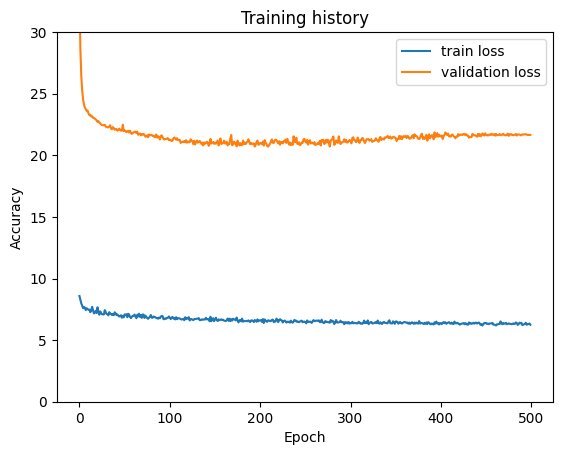

In [33]:
import matplotlib.pyplot as plt

#Plot training and validation accuracy
plt.plot(history["train_loss"], label='train loss')
plt.plot(history["valid_loss"], label='validation loss')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 30]);
print(best_valid_loss)

IndexError: list index out of range

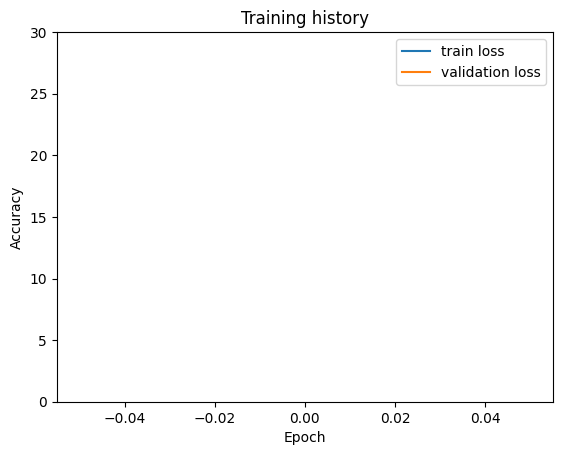

In [34]:
plt.plot(history["train_loss"][1500:1800], label='train loss')
plt.plot(history["valid_loss"][1500:1800], label='validation loss')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 30]);
print(history["losses"][5])

In [ ]:
def prevision_mocap(model, input, device, max_output_length):
    model.eval()
    with torch.no_grad():
        input["pose"] = (torch.tensor(input["pose"]))
        input["pose"] = (input["pose"].float()).to(device)
        
        hidden, cell = model.encoder(input["pose"])
        previsions = input["pose"][-1].tolist()

        concat_hidden = model.actionclassifier(input["input_ids"].to(device), input["attention_mask"].to(device))
        concat_hidden = concat_hidden.unsqueeze(0)

        hidden = torch.cat((concat_hidden, hidden), dim=2).to(model.device)
        # hidden = [n layers * n directions, batch size, 2*hidden dim]
        concat_cell = torch.zeros(1, hidden.shape[1], 768).to(model.device)
        cell = torch.cat((concat_cell, cell), dim=2).to(model.device)
        # cell = [n layers * n directions, batch size, 2*hidden dim]

        for _ in range(max_output_length):
            inputs_tensor = torch.tensor([previsions[-1]]).to(device)

            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            output = output.tolist()
            previsions.append(output[0])
    
    del previsions[0]
    return np.array(previsions)


In [ ]:
rand_x = random.randint(0, len(dataset_copy["pose"]))

input_mocap = np.array(dataset_copy["pose"][rand_x][:50])

deleted = input_mocap[:, indexes_to_exclude]

input_mocap_test = np.delete(input_mocap, indexes_to_exclude, axis=1)

expected_output_mocap = np.array(dataset_copy["pose"][rand_x][-25:])

test = {'pose': [input_mocap_test], 'description': [dataset_copy["description"][rand_x]]}
test = pd.DataFrame(test)
input_dataloader = get_data_loader(test, 1, MAX_LEN)

input = next(iter(input_dataloader))

prevision = prevision_mocap(
    model,
    input,
    device,
    max_output_length = expected_output_mocap.shape[0]
)

for i, column in enumerate(deleted[-25:].T):
    prevision = np.insert(prevision, indexes_to_exclude[i], column, axis=1)

input_mocap = input_mocap.reshape(50, 24, 3)
print(input_mocap.shape)

expected_output_mocap = expected_output_mocap.reshape(25, 24, 3)
print(expected_output_mocap.shape)

prevision = prevision.reshape(25, 24, 3)
print(prevision.shape)

/tmp/ipykernel_235049/1205961236.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input["pose"] = (torch.tensor(input["pose"]))


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 1 but got size 4 for tensor number 1 in the list.

In [ ]:

input_mocap = kine.compute_fk(input_mocap, apply_root_rotation=True)
expected_output_mocap = kine.compute_fk(expected_output_mocap, apply_root_rotation=True)
prevision = kine.compute_fk(prevision, apply_root_rotation=True)

motions_list = [[input_mocap], [expected_output_mocap, prevision]]
subplot_ids = [[0], [0,1]]
subplot_titles = [['Input_mocap'], ['Expected_output_mocap', 'Prevision']]
camera_orientations = [[CameraOrientation(100, 20)], [CameraOrientation(100, 20), CameraOrientation(100, 20)]]

pose_animation(motions_list[0], SmplConstants.PARENTS, animation_framerate = 25, subplot_ids=subplot_ids[0], 
               camera_orientations=camera_orientations[0], subplot_titles=subplot_titles[0],
               fig_opts={'dpi':90}, animation_mode=AnimationMode.HTML)

pose_animation(motions_list[1], SmplConstants.PARENTS, animation_framerate = 25, subplot_ids=subplot_ids[1], 
               camera_orientations=camera_orientations[1], subplot_titles=subplot_titles[1],
               animation_mode=AnimationMode.HTML)